To use this notebook you need to create yourself a kaggle.json file containing your kaggle username and your kaggle api key that you need to create in your settings. The JSON should look like this. {
  "username": "YOUR_USERNAME",
  "key": "YOUR_API_KEY"
}




In [1]:
from google.colab import files
uploaded = files.upload()   # choose kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d borhanitrash/alzheimer-mri-disease-classification-dataset
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!pip install -q datasets pillow

Dataset URL: https://www.kaggle.com/datasets/borhanitrash/alzheimer-mri-disease-classification-dataset
License(s): apache-2.0
  0% 0.00/26.0M [00:00<?, ?B/s]
100% 26.0M/26.0M [00:00<00:00, 738MB/s]
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 86% 128M/149M [00:00<00:00, 1.33GB/s]
100% 149M/149M [00:00<00:00, 1.22GB/s]


In [10]:
# Import all necessary libaries
import zipfile
import os
from pathlib import Path
from datasets import load_dataset
from PIL import Image
import io
import shutil
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

#### Now create the alzheimer dataset

In [5]:
zip_path = "alzheimer-mri-disease-classification-dataset.zip"
extract_path = "raw_alzheimer"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped to:", extract_path)

raw_root = Path("raw_alzheimer")
alz_dir = next(raw_root.iterdir())
data_dir = alz_dir / "Data"

print("Alzheimer root:", alz_dir)
print("Data dir:", data_dir)
list(data_dir.iterdir())

train_files = [str(p) for p in data_dir.glob("train*.parquet")]
test_files  = [str(p) for p in data_dir.glob("test*.parquet")]

ds = load_dataset(
    "parquet",
    data_files={"train": train_files, "test": test_files}
)

dataset_train = ds["train"]
dataset_test  = ds["test"]

Unzipped to: raw_alzheimer
Alzheimer root: raw_alzheimer/Alzheimer MRI Disease Classification Dataset
Data dir: raw_alzheimer/Alzheimer MRI Disease Classification Dataset/Data


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [6]:
base = Path("data") / "alzheimer"
(base / "yes").mkdir(parents=True, exist_ok=True)
(base / "no").mkdir(parents=True, exist_ok=True)


def get_pil_image(image_dict):
    return Image.open(io.BytesIO(image_dict["bytes"])).convert("RGB")

def label_to_folder(label: int) -> str:
    return "no" if label == 2 else "yes"

def save_split(ds, split_name: str):
    for i, example in enumerate(ds):
        img = get_pil_image(example["image"])
        label = example["label"]

        folder = label_to_folder(label)
        out_path = base / folder / f"{split_name}_{i}.png"

        img.save(out_path)

        if i % 500 == 0:
            print(f"[{split_name}] saved {i} images...")

save_split(dataset_train, "train")
save_split(dataset_test, "test")

print("Done!")

[train] saved 0 images...
[train] saved 500 images...
[train] saved 1000 images...
[train] saved 1500 images...
[train] saved 2000 images...
[train] saved 2500 images...
[train] saved 3000 images...
[train] saved 3500 images...
[train] saved 4000 images...
[train] saved 4500 images...
[train] saved 5000 images...
[test] saved 0 images...
[test] saved 500 images...
[test] saved 1000 images...
Done!


##### Now unzip the first tumor dataset and create the tumor folder

In [7]:
zip_path = Path("brain-tumor-mri-dataset.zip")
extract_path = Path("raw_tumor")

extract_path.mkdir(parents=True, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_path)

print("Extracted to:", extract_path)

tumor_dir = Path("data/tumor")
(tumor_dir / "yes").mkdir(parents=True, exist_ok=True)
(tumor_dir / "no").mkdir(parents=True, exist_ok=True)

tumor_dir

Extracted to: raw_tumor


PosixPath('data/tumor')

In [8]:
# Source folders
root = Path("raw_tumor")
train_dir = root / "Training"
test_dir = root / "Testing"

# Target folders
target = Path("data/tumor")
(target / "yes").mkdir(parents=True, exist_ok=True)
(target / "no").mkdir(parents=True, exist_ok=True)

def copy_images(src, dst):
    src, dst = Path(src), Path(dst)
    count = 0
    for img in src.rglob("*"):
        if img.suffix.lower() in {".jpg", ".jpeg", ".png"}:
            shutil.copy(img, dst / img.name)
            count += 1
    print(f"Copied {count} → {dst}")

# Classes
tumor_classes = ["glioma", "meningioma", "pituitary"]
no_tumor_class = "notumor"

for cls in tumor_classes:
    copy_images(train_dir / cls, target / "yes")

copy_images(train_dir / no_tumor_class, target / "no")

for cls in tumor_classes:
    copy_images(test_dir / cls, target / "yes")

copy_images(test_dir / no_tumor_class, target / "no")


Copied 1321 → data/tumor/yes
Copied 1339 → data/tumor/yes
Copied 1457 → data/tumor/yes
Copied 1595 → data/tumor/no
Copied 300 → data/tumor/yes
Copied 306 → data/tumor/yes
Copied 300 → data/tumor/yes
Copied 405 → data/tumor/no


- There are 5120 Training Images for Alzheimer Detection and 1280 Test Images so in total 6400.
- There are 7023 Images in the Tumor Detection Dataset with different tumors
- The total dataset size is then 13423
- Now turn the data into a final datset which contains 3 different classes for healthy, alzheimer and tumor

In [9]:
# Source directories
alz_dir = Path("data/alzheimer")
tumor_dir = Path("data/tumor")

# Target unified dataset
final_root = Path("final_data")
(final_root / "0_healthy").mkdir(parents=True, exist_ok=True)
(final_root / "1_alzheimer").mkdir(parents=True, exist_ok=True)
(final_root / "2_tumor").mkdir(parents=True, exist_ok=True)

def copy_images(src, dst):
    src, dst = Path(src), Path(dst)
    count = 0
    for img in src.rglob("*"):
        if img.suffix.lower() in {".jpg", ".jpeg", ".png"}:
            target_path = dst / img.name

            # Avoid filename collisions
            if target_path.exists():
                target_path = dst / (img.stem + "_dup" + img.suffix)

            shutil.copy(img, target_path)
            count += 1
    print(f"Copied {count} images → {dst}")


# 0 = HEALTHY
copy_images(alz_dir / "no", final_root / "0_healthy")
copy_images(tumor_dir / "no", final_root / "0_healthy")

# 1 = ALZHEIMER
copy_images(alz_dir / "yes", final_root / "1_alzheimer")

# 2 = TUMOR
copy_images(tumor_dir / "yes", final_root / "2_tumor")


Copied 3200 images → final_data/0_healthy
Copied 2000 images → final_data/0_healthy
Copied 3200 images → final_data/1_alzheimer
Copied 5023 images → final_data/2_tumor


##### Now generate the dataset for training, validation and testing

In [11]:
IMG_SIZE = 224
# TODO: Try out different data augmentations
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # grayscale-like MRI
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

data_root = Path("final_data")

full_dataset = datasets.ImageFolder(
    root=data_root,
    transform=train_transform   # we'll swap for val/test later
)

print("Classes:", full_dataset.classes)
print("class_to_idx:", full_dataset.class_to_idx)
print("Total images:", len(full_dataset))


Classes: ['0_healthy', '1_alzheimer', '2_tumor']
class_to_idx: {'0_healthy': 0, '1_alzheimer': 1, '2_tumor': 2}
Total images: 13423


In [13]:
total_size = len(full_dataset)
train_size = int(0.85 * total_size)
val_size   = int(0.10 * total_size)
test_size  = total_size - train_size - val_size

train_ds, val_ds, test_ds = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Override transforms for val/test
val_ds.dataset.transform = val_test_transform
test_ds.dataset.transform = val_test_transform

len(train_ds), len(val_ds), len(test_ds)


(11409, 1342, 672)

In [14]:
BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


In [15]:
images, labels = next(iter(train_loader))
print("Batch image tensor shape:", images.shape)   # (B, C, H, W)
print("Batch labels:", labels[:10])

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Batch image tensor shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([2, 1, 1, 0, 2, 2, 2, 2, 2, 1])


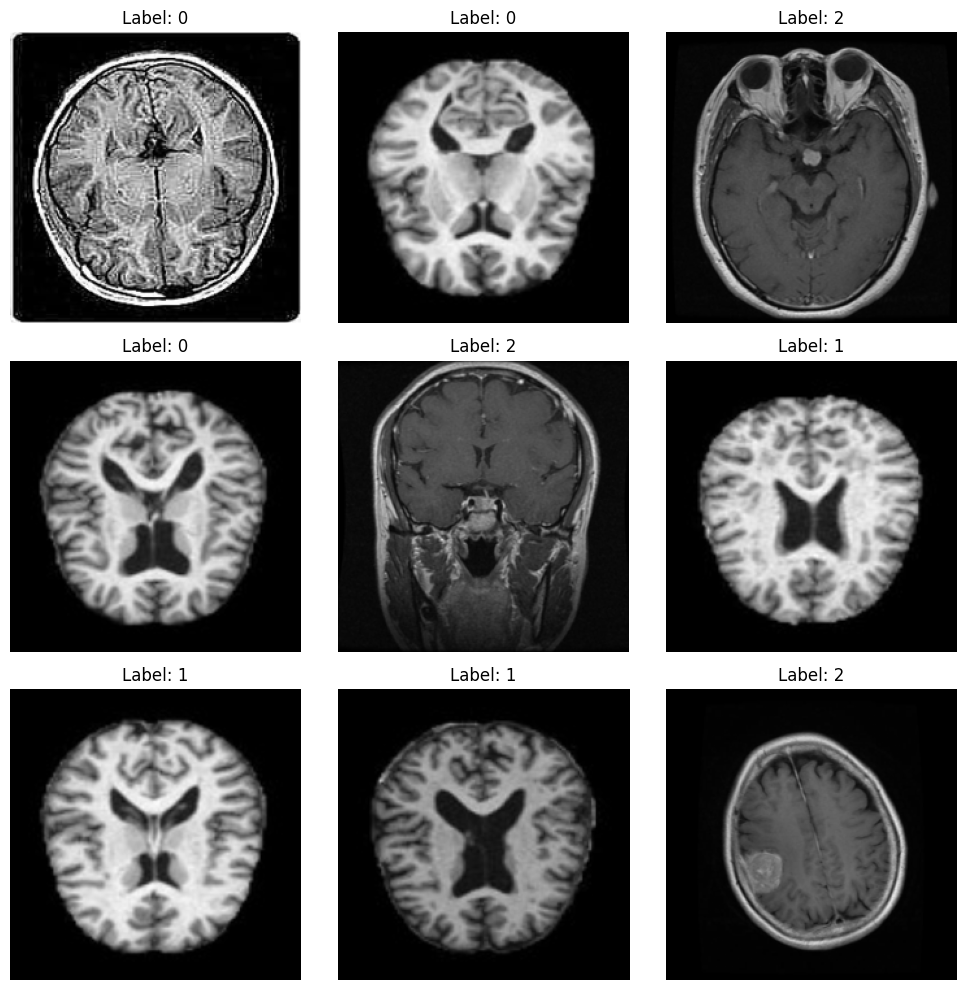

In [17]:
import matplotlib.pyplot as plt
import random

# Pick 9 random indices
indices = random.sample(range(len(train_ds)), 9)

plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices):
    img, label = train_ds[idx]
    img = img.permute(1, 2, 0)  # convert CHW -> HWC for plotting
    img = img * 0.5 + 0.5       # unnormalize (because we normalized to mean=0.5 std=0.5)

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.tight_layout()
plt.show()


#### Here we can now train, validate and test different augmentation, models and use different methods to use explainable AI